In [4]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
df_train=pd.read_csv('Prediction/Datasets/train.csv')
df_test=pd.read_csv('Prediction/Datasets/test.csv')

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [6]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Imputing**

In [7]:
df_train['Age']=df_train['Age'].fillna(df_train.groupby(['SibSp'])['Age'].transform('mean'))
df_train['Age']=df_train['Age'].fillna(df_train['Age'].mode()[0])
df_train['Fare']=df_train['Fare'].fillna(df_train['Fare'].mode()[0])
df_train['Embarked']=df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])
df_train['Cabin']=df_train['Cabin'].fillna(df_train['Cabin'].mode()[0])

**Featrure Engineering**

In [8]:
def addfeatures(data):
    data['Title']=data.Name.str.extract('((?:Mr\.|Mrs\.|Miss\.|Ms\.))')[0].str.lower()
    data['cabin_class']=data.Cabin.str.extract('(^[a-zA-Z])')[0].str.lower()
    data['ticket_class']=data.Ticket.str.extract('^([\w\-]+)')[0].str.extract('([A-Za-z])')
    data['Title']=data['Title'].fillna(data['Title'].mode()[0])
    data['ticket_class']=data['ticket_class'].fillna(data['ticket_class'].mode()[0])
    data=data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
    return data
df_train=addfeatures(df_train)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_train.drop('Survived',axis=1),
                                                    df_train['Survived'], test_size=0.2, random_state=42)

**Scaling the features and one hot encoding with pipeline**

In [10]:
preprocess = make_column_transformer((['Age', 'Fare'], StandardScaler()),
                                     (['Sex','Embarked','Title','cabin_class','ticket_class'], OneHotEncoder()))
clf = RandomForestClassifier(n_estimators=100,random_state=0)
model = make_pipeline(preprocess,clf)
model.fit(x_train,y_train)

C:\Users\bhara\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:732: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['Age', 'Fare']), ('onehotencoder', OneHotEncoder(categorical_fea...mators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [11]:
model.score(x_test,y_test)

0.7541899441340782

**Check correlation**

In [12]:
pd.concat([x_train,y_train],axis=1).corr()['Survived'].sort_values()

Pclass     -0.321750
Age        -0.058472
SibSp      -0.047602
Parch       0.078311
Fare        0.246641
Survived    1.000000
Name: Survived, dtype: float64

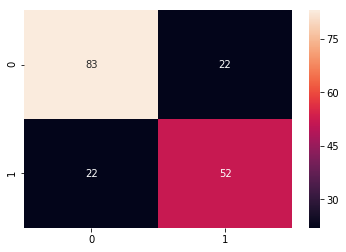

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred=model.predict(x_test)
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)

In [2]:
import pickle
#pickle.dump(model, open("Webapp/flaskr/model.pkl","wb"))

In [3]:
pickle.load(open("Webapp/flaskr/model.pkl","rb"))

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['Age', 'Fare']), ('onehotencoder', OneHotEncoder(categorical_fea...mators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [577]:
dff={'PassengerId': '5', 'Age': '55', 'Fare': '55', 'Name': 'fgsfg', 'Pclass': '2', 'SibSp': '3', 'Parch': '4', 'Embarked': 'S', 'Cabin': 'C', 'Sex': 'male'}

In [582]:
df_train.Ticket.mode()

0        1601
1      347082
2    CA. 2343
dtype: object

In [583]:
val=pd.DataFrame.from_dict(dff,orient='index').T
val['Ticket']='CA. 2343'

In [585]:
model.predict(val)

IndexError: index out of bounds

In [586]:
val

,PassengerId,Age,Fare,Name,Pclass,SibSp,Parch,Embarked,Cabin,Sex,Ticket,Title,cabin_class,ticket_class
0,5,55,55,fgsfg,2,3,4,S,C,male,CA. 2343,NaN,c,C
